# **Mapping Reddit Conversations on Climate Change Using NLP**

1. Setup:
This section imports required libraries for data loading, visualization, word frequency analysis, and transformer-based sentiment and toxicity classification.

In [92]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import os


2. Data Import:
This project uses two datasets: the top Reddit posts mentioning "climate change," and a manually curated sample from selected climate-related subreddits.

In [93]:
# Define file paths
main_base_path = "C:/Users/asmae/Downloads"
main_filename = "top climate chage posts  - climate_change_top_posts (5).csv"
main_path = os.path.join(main_base_path, main_filename)

subreddit_base_path = "C:/Users/asmae/Documents/GitHub/climate change misinformation"
subreddit_filename = "climate_subreddit_sample.csv"
subreddit_path = os.path.join(subreddit_base_path, subreddit_filename)

# Load data
main_df = pd.read_csv(main_path)
main_df['text'] = main_df['title'].fillna('') + ' ' + main_df['selftext'].fillna('')

sub_df = pd.read_csv(subreddit_path)
sub_df['text'] = sub_df['title'].fillna('') + ' ' + sub_df['selftext'].fillna('')

3. Subreddit Distribution:
This bar chart shows the most active subreddits discussing climate change based on post frequency.

C:\Users\asmae\AppData\Local\Temp\ipykernel_40264\157753676.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


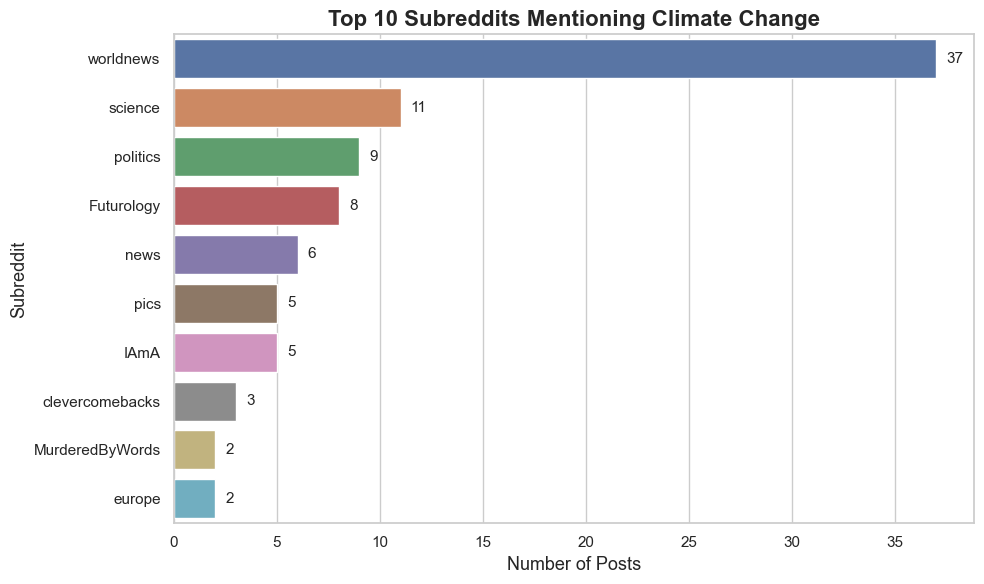

In [95]:
# Visualize top 10 subreddits
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
barplot = sns.barplot(
    x=subreddit_counts.values,
    y=subreddit_counts.index,
    palette="deep"
)

# Add labels and title with academic font settings
plt.title('Top 10 Subreddits Mentioning Climate Change', fontsize=16, weight='bold')
plt.xlabel('Number of Posts', fontsize=13)
plt.ylabel('Subreddit', fontsize=13)

# Add value labels
for i, v in enumerate(subreddit_counts.values):
    plt.text(v + 0.5, i, str(v), va='center', fontsize=11)

# Tidy up plot
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


4. Post Topics:
Visualizes the five most common manually assigned categories from the climate posts.

C:\Users\asmae\AppData\Local\Temp\ipykernel_40264\2191612155.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="muted")


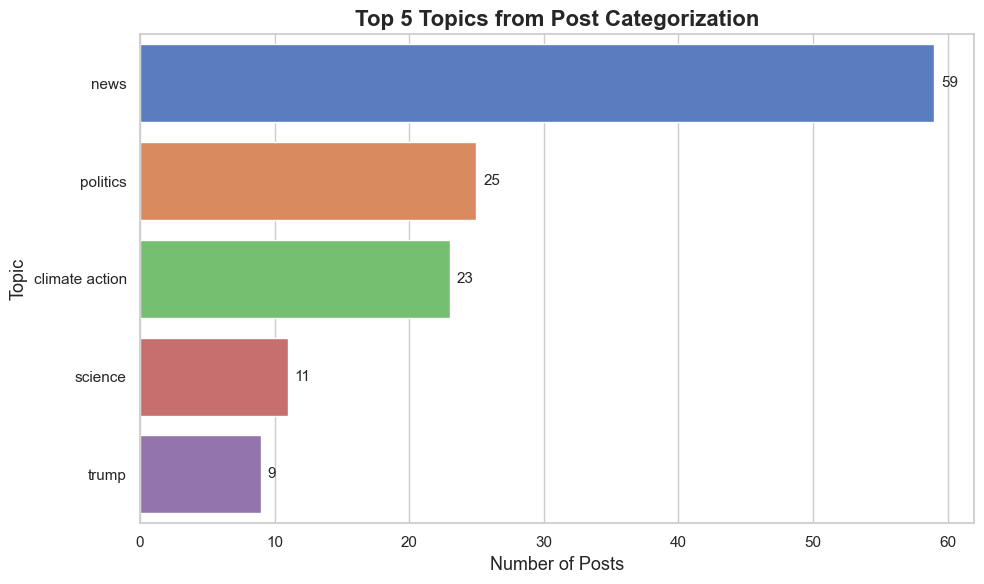

In [96]:
# 3. Visualize manual category classification
main_df['category'] = main_df['category'].fillna('Other')
exploded_df = main_df.assign(topic_split=main_df['category'].str.split(',')).explode('topic_split')
exploded_df['topic_split'] = exploded_df['topic_split'].str.strip()
topic_counts = exploded_df['topic_split'].value_counts().head(5)
plt.figure(figsize=(10,6))
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="muted")
plt.title('Top 5 Topics from Post Categorization', fontsize=16, weight='bold')
plt.xlabel('Number of Posts', fontsize=13)
plt.ylabel('Topic', fontsize=13)
for i, v in enumerate(topic_counts.values):
    plt.text(v + 0.5, i, str(v), va='center', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

5. Word Clouds by Subreddit:
Word clouds visualize the most common descriptive terms used in each subreddit, after filtering out generic or repetitive terms.

climateskeptics: [('truth', 5), ('cows', 4), ('stop', 4), ('blocking', 3), ('scam', 3), ('real', 3), ('work', 3), ('man', 2), ('hoax', 2), ('think', 2)]


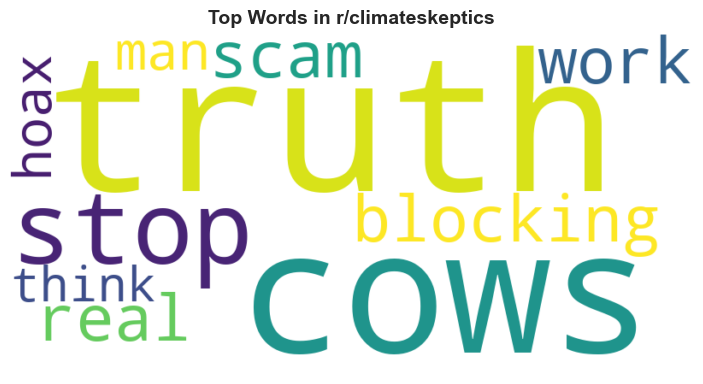

climatechange: [('scientists', 18), ('trump', 13), ('nuclear', 13), ('global', 11), ('energy', 10), ('power', 9), ('people', 9), ('warming', 9), ('world', 8), ('ice', 8)]


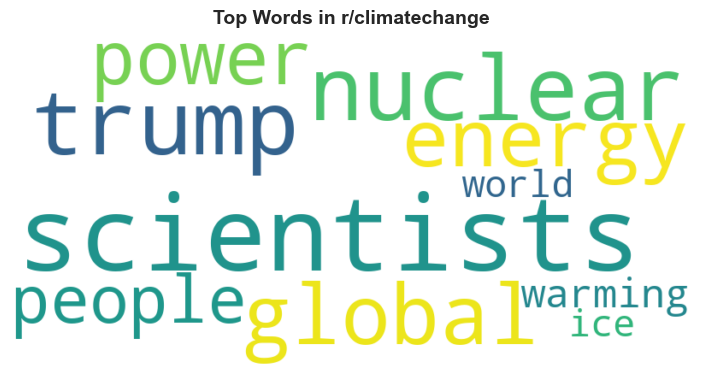

climateoffensive: [('people', 32), ('contact', 25), ('governor', 24), ('million', 15), ('carbon', 14), ('environmental', 13), ('know', 12), ('koch', 12), ('charles', 12), ('one', 11)]


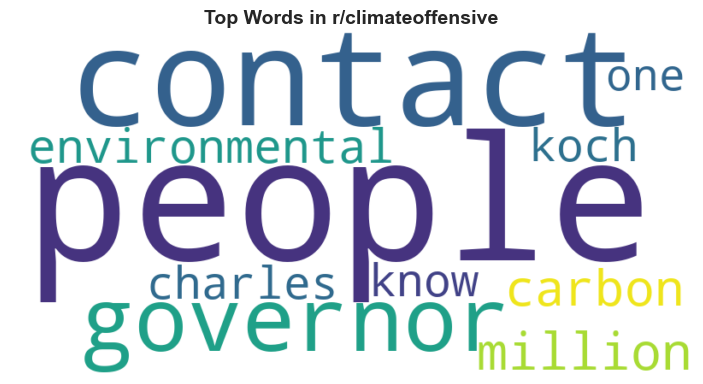

In [97]:
# 4. Generate word clouds from subreddit dataset (nouns/adjectives only)
def get_frequent_keywords(texts, skip_words):
    words = []
    for text in texts:
        if isinstance(text, str) and text.strip():
            tokens = text.lower().split()
            filtered = [word for word in tokens if word.isalpha() and word not in stop_words and word not in skip_words and len(word) > 2]
            words.extend(filtered)
    return Counter(words).most_common(10)

# Define custom skip words per subreddit
custom_skips = {
    'climateskeptics': {'climate', 'change', 'years', 'people', 'road', 'cobalt', 'electric'},
    'climatechange': {'climate', 'change', 'like', 'would', 'says', 'charles', 'know', 'one', 'koch'},
    'climateoffensive': {'climate', 'change', 'think', 'made'}
}

for sub in sub_df['subreddit'].unique():
    skip_words = custom_skips.get(sub.lower(), set())
    subset = sub_df[sub_df['subreddit'] == sub]['text']
    top_words = get_frequent_keywords(subset, skip_words)
    if not top_words:
        print(f"Skipping {sub} – no valid words for word cloud.")
        continue
    print(f"{sub}: {top_words}")
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(dict(top_words))

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Top Words in r/{sub}', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


6. Sentiment and Toxicity Scoring:
Each Reddit post is evaluated for emotional tone and toxicity using transformer-based models.

In [98]:
from transformers import pipeline

# Load models
sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
toxicity_model = pipeline("text-classification", model="unitary/toxic-bert")

# Sentiment function
def get_sentiment(text):
    try:
        result = sentiment_model(text[:512])[0]
        label = result['label']
        score = result['score']
        return label, score
    except:
        return 'ERROR', 0

# Toxicity function
def get_toxicity(text):
    try:
        result = toxicity_model(text[:512])[0]
        return result['score']
    except:
        return 0


sub_df['text_clean'] = sub_df['text'].fillna('').str.lower()
sub_df[['sentiment_label', 'sentiment_score']] = sub_df['text_clean'].apply(lambda x: pd.Series(get_sentiment(x)))
sub_df['toxicity'] = sub_df['text_clean'].apply(get_toxicity)

# Convert sentiment labels to numeric
label_map = {'LABEL_0': -1, 'LABEL_1': 0, 'LABEL_2': 1}
sub_df['sentiment_numeric'] = sub_df['sentiment_label'].map(label_map)

sub_df.to_csv("climate_sentiment_toxicity_results.csv", index=False)


Device set to use cpu
Device set to use cpu


7. Toxicity Comparison:
This box plot shows how toxicity scores vary across subreddits, highlighting more hostile discourse in certain communities.

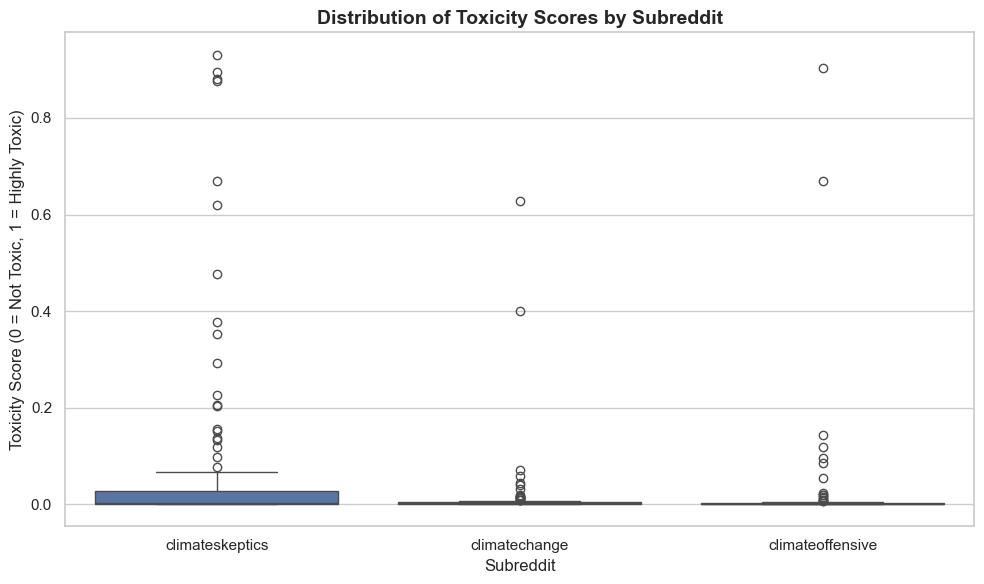

In [99]:
# Box Plot: Toxicity Score by Subreddit

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (update the path if needed)
base_path = "C:/Users/asmae/Documents/GitHub/Climate Change Misinformation"
filename = "climate_sentiment_toxicity_results.csv"
file_path = os.path.join(base_path, filename)

# Load the data
df = pd.read_csv(file_path)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='subreddit', y='toxicity')
plt.title("Distribution of Toxicity Scores by Subreddit", fontsize=14, weight='bold')
plt.xlabel("Subreddit")
plt.ylabel("Toxicity Score (0 = Not Toxic, 1 = Highly Toxic)")
plt.tight_layout()
plt.show()